In [1]:
import numpy as np

import sympy as sym

import itertools

In [2]:
from importlib.machinery import SourceFileLoader

main = SourceFileLoader(
    "main", "main.py"
).load_module()

from main import *

In [98]:
import matplotlib.pyplot as plt

import matplotlib

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import matplotlib.colors as colors

In [72]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

**Payoffs Formulation**

In [5]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(1000):
    
    p1, p2, q1, q2 = np.random.random(4)
    
    one_bit_M = transition_matrix_one_bit(p=[p1, p2], q=[q1, q2])
    
    two_bit_M = transition_matrix_two_bit(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2])
    
    ss_one_bit = invariant_distribution(one_bit_M)
    ss_two_bit = invariant_distribution(two_bit_M)    

    
    assert np.isclose(ss_one_bit @ np.array([b - c, -c, b, 0]),
                      ss_two_bit @ payoffs_vector(c, b))

**Cooperation**

In [6]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(1000):
    
    p1, p2, q1, q2 = np.random.random(4)
    
    one_bit_M = transition_matrix_one_bit(p=[p1, p2], q=[q1, q2])
    
    two_bit_M = transition_matrix_two_bit(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2])
    
    ss_one_bit = invariant_distribution(one_bit_M)
    ss_two_bit = invariant_distribution(two_bit_M) 
    
    assert np.isclose(ss_one_bit[0] + ss_one_bit[1],
                     (ss_two_bit[0] + ss_two_bit[4] + ss_two_bit[8] + ss_two_bit[12] +
                      ss_two_bit[1] + ss_two_bit[5] + ss_two_bit[9] + ss_two_bit[13]))

In [7]:
def cooperation(ss):
    return (ss[0] + ss[4] + ss[8] + ss[12] +
            ss[1] + ss[5] + ss[9] + ss[13])

**Checks for matlab code**

In [8]:
p1, p2 = np.random.random(4), np.random.random(4)

In [9]:
p1, p2

(array([0.48957168, 0.77317044, 0.9690389 , 0.26523513]),
 array([0.47410322, 0.91145109, 0.46585398, 0.63095081]))

In [10]:
M  = transition_matrix_two_bit(p1, p2)

ss = invariant_distribution(M) 

In [11]:
ss

array([0.11983649, 0.13509718, 0.05956   , 0.06716756, 0.07388903,
       0.08248378, 0.05046434, 0.05624635, 0.11982726, 0.03538482,
       0.04461744, 0.01188721, 0.06810845, 0.01011773, 0.05707495,
       0.00823742])

In [12]:
c = 0.1

In [13]:
ss @ payoffs_vector(c, b)

0.5289034870630169

In [14]:
cooperation(ss)

0.6447447294734462

In [16]:
(ss_two_bit[0] + ss_two_bit[4] + ss_two_bit[8] + ss_two_bit[12] +
            ss_two_bit[1] + ss_two_bit[5] + ss_two_bit[9] + ss_two_bit[13])

0.5543569774328786

**Evolutionary "simulations"**

In [17]:
import pandas as pd

In [19]:
names = ["p_1", "p_2", "p_3", "p_4", "t", "cooperation"]
cs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [107]:
dfs = [pd.read_csv(f"data/matlab_two_bits_c_{c}.csv", names=names) for c in cs]

df2s = [pd.read_csv(f"data/matlab_one_bit_b_1_c_{c}.csv", names=names) for c in cs]

In [110]:
dfs = [df.drop_duplicates() for df in dfs]

df2s = [df.drop_duplicates() for df in df2s]

In [111]:
def frequencies(dfs):
    
    for df in dfs:
        frequencies = []
        previous = 0
        for value in df["t"][1:]:
            frequencies.append(value - previous)
            previous = value
        frequencies.append(10 ** 7 - previous)

        df['frequencies'] = np.array(frequencies)
        df['frequencies norm'] = np.array(frequencies) / 10 ** 7
        
    return dfs

In [112]:
dfs = frequencies(dfs)

In [113]:
df2s = frequencies(df2s)

In [88]:
points = [[sum(df['frequencies norm'] * df['cooperation']) for df in dfs], 
          [sum(df['frequencies norm'] * df['cooperation']) for df in df2s]]

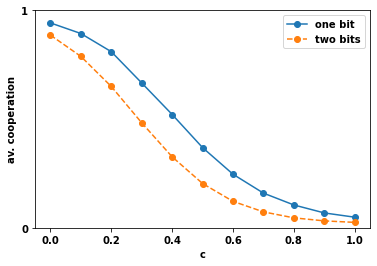

In [89]:
plt.plot(np.linspace(0, 1, 11), points[0], '-o', label='one bit');
plt.plot(np.linspace(0, 1, 11), points[1], '--o', label='two bits');

plt.ylim(0, 1);

plt.yticks(np.arange(0, 2))

plt.xlabel("c")
plt.ylabel("av. cooperation")

plt.legend();

In [93]:
heatmaps = []
extents = []


for df in dfs:
    ps, qs = [], []
    for p, q, v in zip(df["p_1"], df["p_2"], df["frequencies"]):
        for _ in range(int(v)):
            ps.append(p)
            qs.append(q)


    heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=19)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    heatmaps.append(heatmap)
    extents.append(extent)

In [94]:
min_ = min([heatmap.min() for heatmap in heatmaps])

max_ = max([heatmap.max() for heatmap in heatmaps])

In [99]:
reds, blues = matplotlib.cm.get_cmap("Oranges"), matplotlib.cm.get_cmap("Blues")

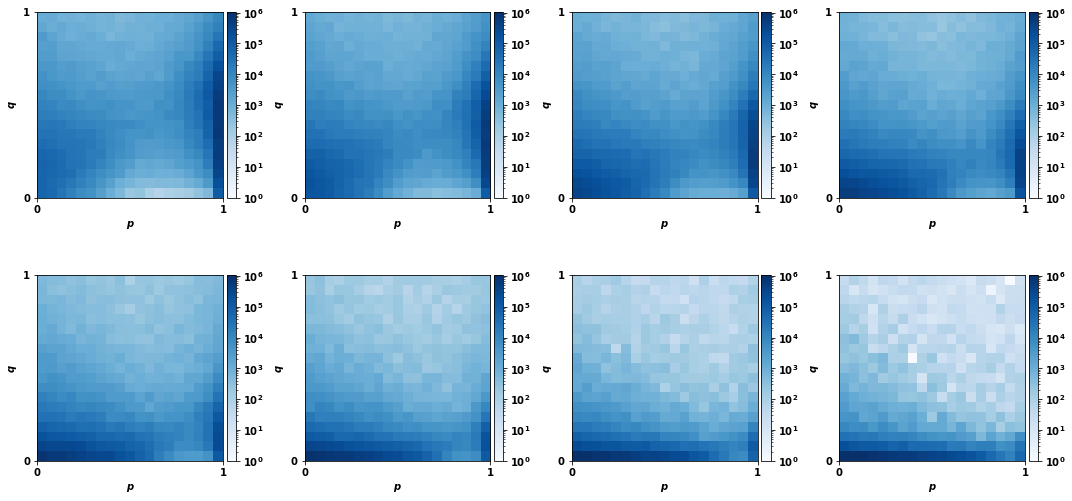

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7.5))

for i, heatmap in enumerate(heatmaps[1:-1]):
    
    index = (int(i / 4), (i % 4))
    
    im = axes[index].imshow(heatmap.T, extent=extent, origin="lower",
                            norm=colors.LogNorm(vmin=min_, vmax=max_),
                            cmap=blues)

    divider = make_axes_locatable(axes[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    axes[index].set_xticks(np.linspace(0, 1, 2))
    axes[index].set_yticks(np.linspace(0, 1, 2));
    axes[index].set_xlabel("$p$")
    axes[index].set_ylabel("$q$")
    
plt.tight_layout()

In [103]:
heatmaps = []
extents = []


for df in df2s:
    ps, qs = [], []
    for p, q, v in zip(df["p_1"], df["p_2"], df["frequencies"]):
        for _ in range(int(v)):
            ps.append(p)
            qs.append(q)


    heatmap, xedges, yedges = np.histogram2d(ps, qs, bins=19)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    heatmaps.append(heatmap)
    extents.append(extent)
    
min_ = min([heatmap.min() for heatmap in heatmaps])

max_ = max([heatmap.max() for heatmap in heatmaps])

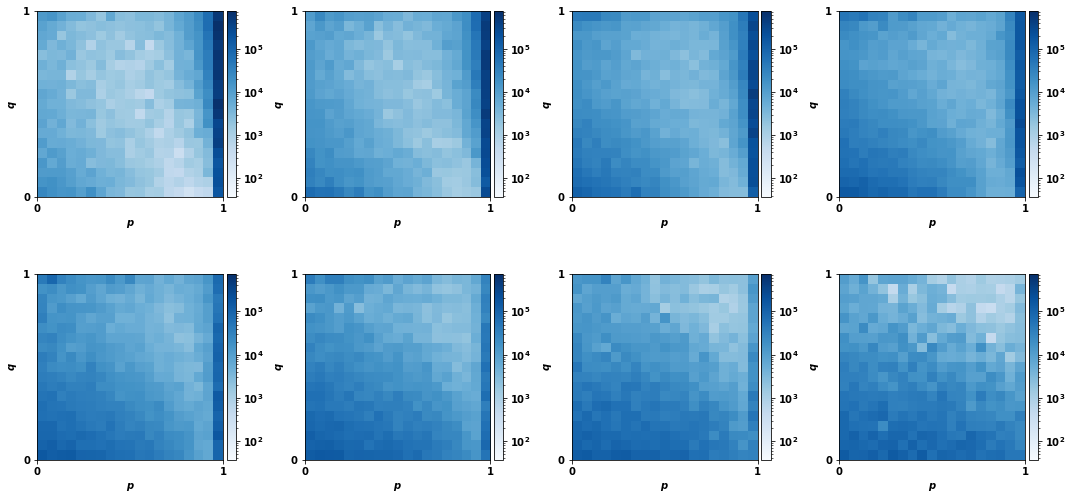

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7.5))

for i, heatmap in enumerate(heatmaps[1:-1]):
    
    index = (int(i / 4), (i % 4))
    
    im = axes[index].imshow(heatmap.T, extent=extent, origin="lower",
                            norm=colors.LogNorm(vmin=min_, vmax=max_),
                            cmap=blues)

    divider = make_axes_locatable(axes[index])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    axes[index].set_xticks(np.linspace(0, 1, 2))
    axes[index].set_yticks(np.linspace(0, 1, 2));
    axes[index].set_xlabel("$p$")
    axes[index].set_ylabel("$q$")
    
plt.tight_layout()